# Gestures and Actions Recognition


## Detecting body points

### Importing the libraries

In [44]:
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import numpy as np

### Loading the image

In [92]:
image = cv2.imread('/content/image1.jpg')

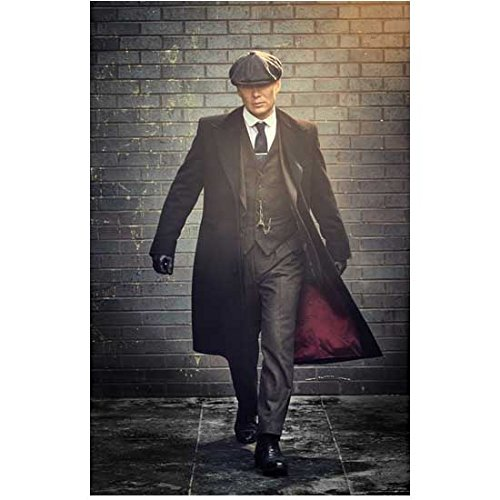

In [93]:
cv2_imshow(image)

In [94]:
image.shape, f'number of pixels: {image.shape[0] * image.shape[1] * 3}'

((500, 500, 3), 'number of pixels: 750000')

In [95]:
type(image)

numpy.ndarray

In [96]:
#blob format changes array orders of an image (required for our model)
image_blob = cv2.dnn.blobFromImage(image = image, scalefactor = 1.0 / 255,
                                   size = (image.shape[1], image.shape[0]))


In [97]:
f'common format: {image.shape}', f'blob format: {image_blob.shape}' # batch(num of image), channel, width, height

('common format: (500, 500, 3)', 'blob format: (1, 3, 500, 500)')

### Loading the pre-trained neural network

- Caffe Deep Learning framework: https://caffe.berkeleyvision.org/

In [78]:
network = cv2.dnn.readNet('/content/pose_deploy_linevec_faster_4_stages.prototxt',
                                   '/content/pose_iter_160000.caffemodel')

In [20]:
#network layers
#network.getLayerNames()

In [79]:
#number of network layers
len(network.getLayerNames())

127

### Predicting body points

In [98]:
network.setInput(image_blob)
output = network.forward()

In [99]:
output.shape
#batch (number of image), detected points, location of points, location of points

(1, 44, 63, 63)

In [100]:
position_width = output.shape[3]
position_heigth = output.shape[2]

In [101]:
position_width

63

In [102]:
(image.shape[1] * 28) / 75

186.66666666666666

In [103]:
#for each of 15 body parts, the NN returns X candidate points indicating
#the probablity of location of that part
#the highest probability would be the location of that body part
num_points = 15
points = []
threshold = 0.1
for i in range(num_points):
  #print(i)
  confidence_map = output[0, i, :, :]
  # print(confidence_map) # candidate points
  # print(len(confidence_map))
  _, confidence, _, point = cv2.minMaxLoc(confidence_map)
  #print(confidence) #confidence rate of chosen point as part X (eg head)
  #print(point) #location of part X (eg head)

  #to match the prediction and image orders
  x = int((image.shape[1] * point[0]) / position_width)
  y = int((image.shape[0] * point[1]) / position_heigth)
  #print(x,y)

  #to exclude uncertain prediction (below 10 percent confidence)
  if confidence > threshold:
    cv2.circle(image, (x, y), 5, (0,255,0), thickness = -1)
    cv2.putText(image, '{}'.format(i), (x,y), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255))
    points.append((x,y))
  else:
    points.append(None)

In [104]:
points

[(246, 55),
 (253, 111),
 (206, 126),
 (174, 182),
 (158, 238),
 (301, 126),
 (317, 190),
 (333, 246),
 (222, 253),
 (230, 333),
 (238, 420),
 (277, 253),
 (269, 341),
 (261, 428),
 (253, 190)]

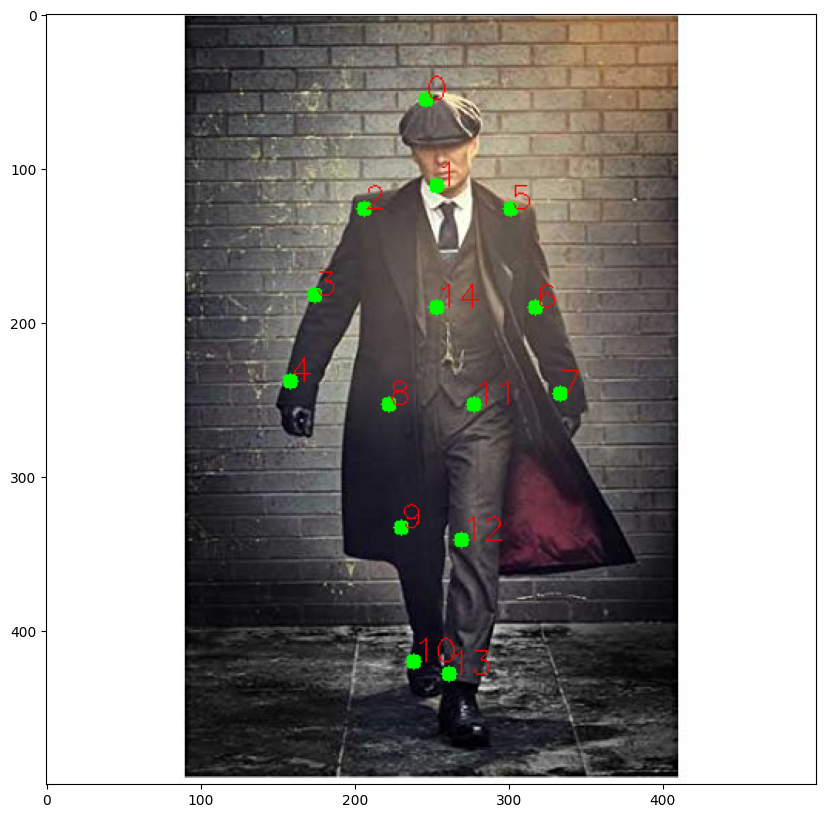

In [105]:
plt.figure(figsize=(14,10))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB));

In [106]:
point_connections = [[0,1], [1,2], [2,3], [3,4], [1,5], [5,6], [6,7],[1,14],
                     [14,8], [8,9], [9,10], [14,11], [11,12], [12,13]]

In [107]:
point_connections

[[0, 1],
 [1, 2],
 [2, 3],
 [3, 4],
 [1, 5],
 [5, 6],
 [6, 7],
 [1, 14],
 [14, 8],
 [8, 9],
 [9, 10],
 [14, 11],
 [11, 12],
 [12, 13]]

In [108]:
for connection in point_connections:
  #print(connection)
  partA = connection[0]
  partB = connection[1]
  #print(partA, partB)
  if points[partA] and points[partB]:
    cv2.line(image, points[partA], points[partB], (255,0,0))

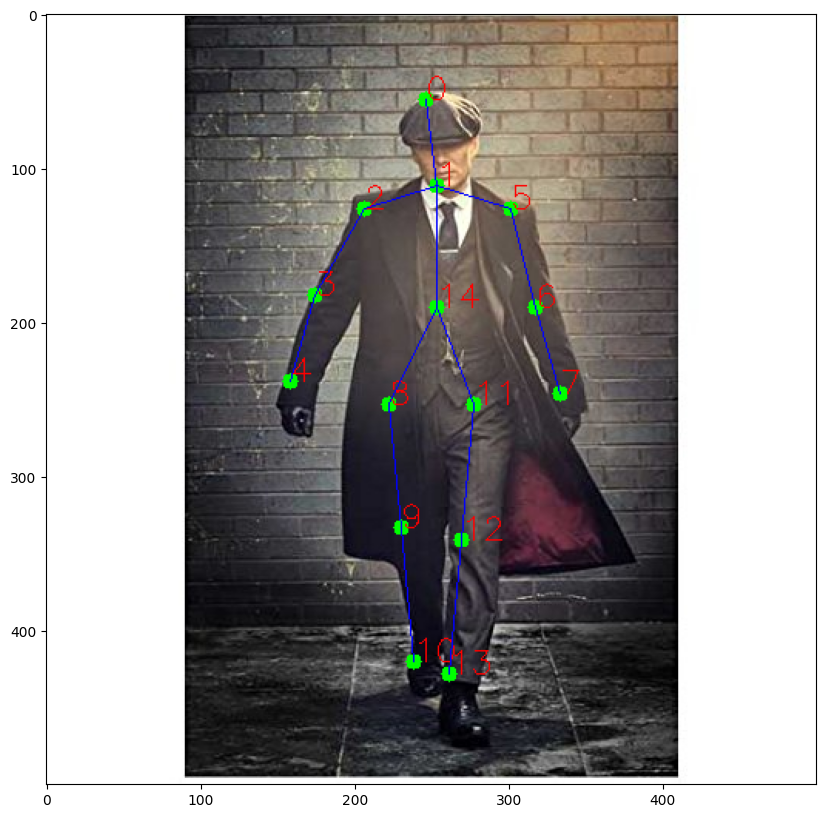

In [109]:
plt.figure(figsize=(14,10))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB));

## Detecting movements (arms above the head)

### Arms above the head in images

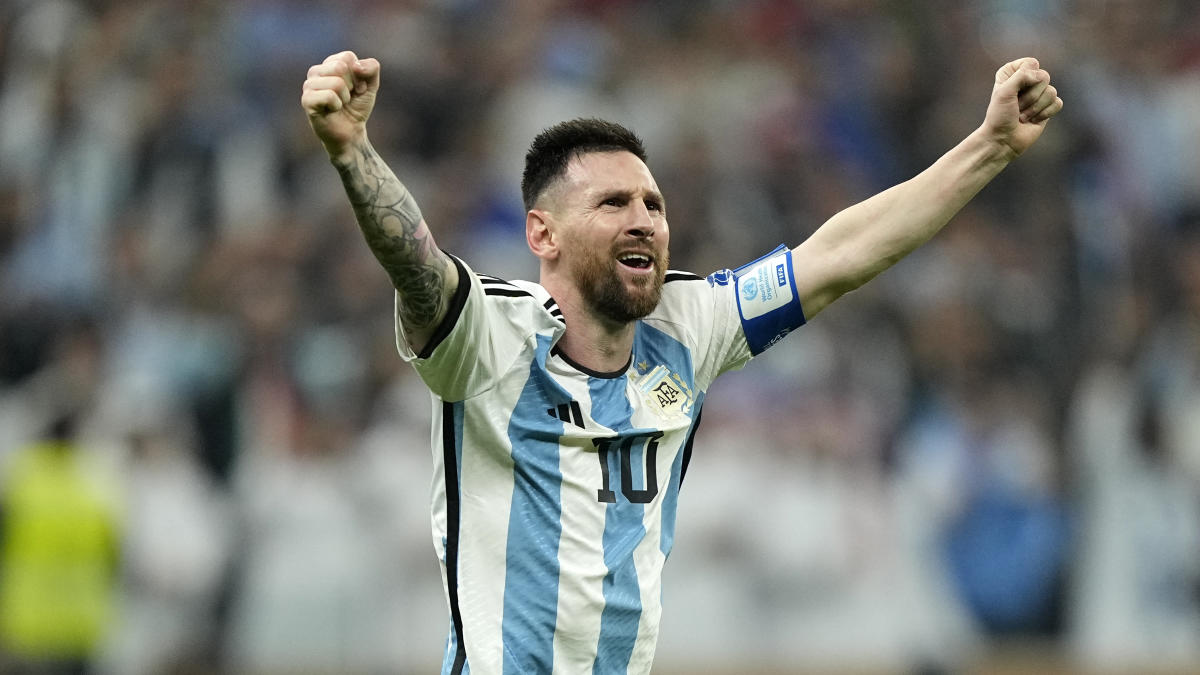

In [112]:
image2 = cv2.imread('/content/image2.jpg')
cv2_imshow(image2)

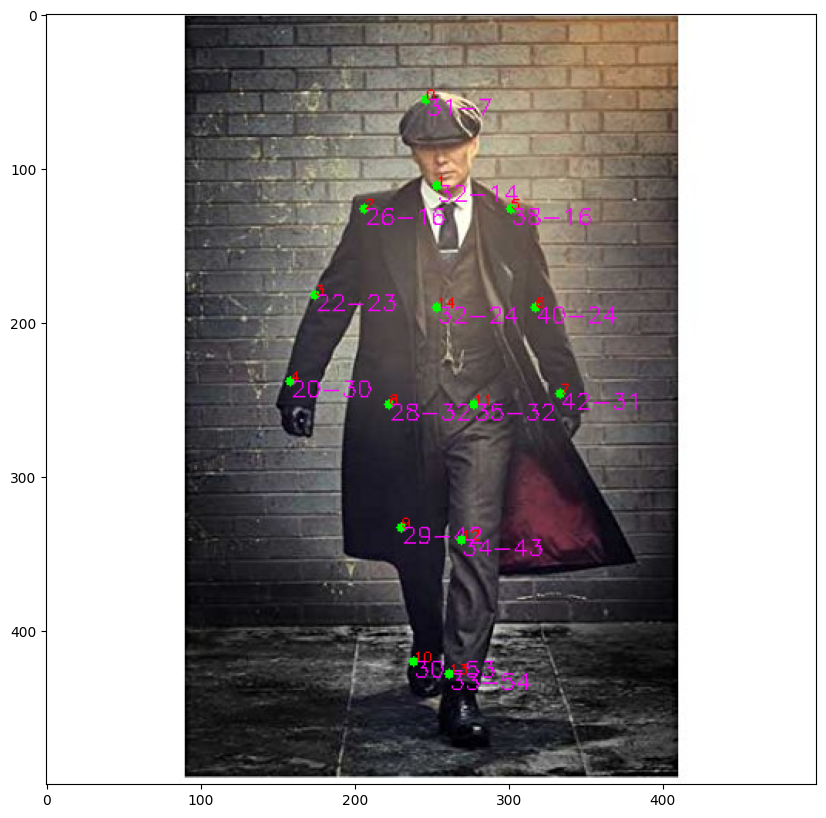

In [117]:
image2 = cv2.imread('/content/image1.jpg')
image_blob2 = cv2.dnn.blobFromImage(image = image2, scalefactor = 1.0 / 255, size = (image2.shape[1], image2.shape[0]))
network.setInput(image_blob2)
output2 = network.forward()
position_width = output2.shape[3]
position_height = output2.shape[2]
num_points = 15
points = []
threshold = 0.1
for i in range(num_points):
  confidence_map = output2[0, i, :, :]
  _, confidence, _, point = cv2.minMaxLoc(confidence_map)
  x = int((image2.shape[1] * point[0]) / position_width)
  y = int((image2.shape[0] * point[1]) / position_height)

  if confidence > threshold:
    cv2.circle(image2, (x, y), 3, (0,255,0), thickness = -1)
    cv2.putText(image2, "{}".format(i), (x, y), cv2.FONT_HERSHEY_SIMPLEX, .3, (0, 0, 255))

    #shows the points (x,y)
    cv2.putText(image2, '{}-{}'.format(point[0], point[1]), (x, y + 10), cv2.FONT_HERSHEY_SIMPLEX, .5, (255,0,255))

    points.append((x, y))
  else:
    points.append(None)

plt.figure(figsize = [14,10])
plt.imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB));

In [120]:
#with position of points for head and arm we can verify whether the arm is above the head or not

def verify_arms_up(points):
  head, right_wrist, left_wrist = 0, 0, 0
  for i, point in enumerate(points):
    #print(i, point)
    if i == 0:
      head = point[1]
    elif i == 4:
      right_wrist = point[1]
    elif i == 7:
      left_wrist = point[1]

  #print(head, right_wrist, left_wrist)
  if right_wrist < head and left_wrist < head:
    return 'Arms are above the head'
  else:
    return 'Arms are not above the head'

In [121]:
verify_arms_up(points)

'Arms are not above the head'

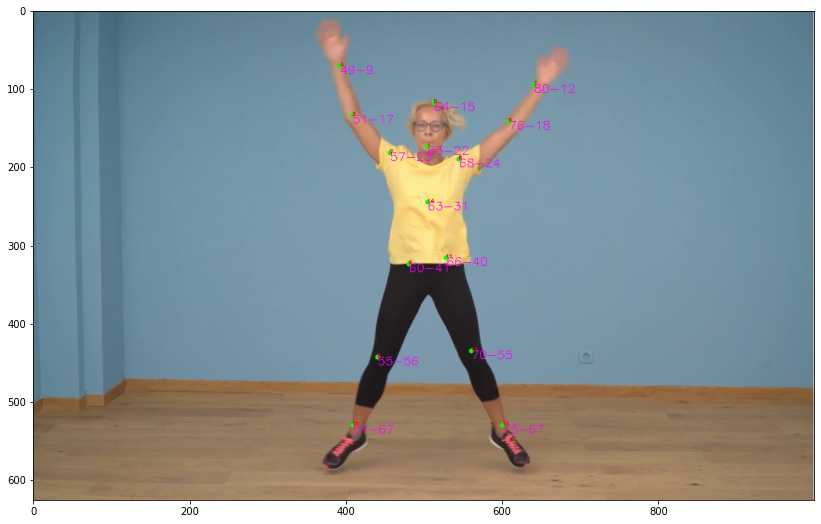

In [ ]:
image = cv2.imread('/content/drive/MyDrive/Cursos - recursos/Computer Vision Masterclass/Images/jump.jpg')
image_blob = cv2.dnn.blobFromImage(image = image, scalefactor = 1.0 / 255, size = (image.shape[1], image.shape[0]))
network.setInput(image_blob)
output = network.forward()
position_width = output.shape[3]
position_height = output.shape[2]
num_points = 15
points = []
threshold = 0.1
for i in range(num_points):
  confidence_map = output[0, i, :, :]
  _, confidence, _, point = cv2.minMaxLoc(confidence_map)
  x = int((image.shape[1] * point[0]) / position_width)
  y = int((image.shape[0] * point[1]) / position_height)

  if confidence > threshold:
    cv2.circle(image, (x, y), 3, (0,255,0), thickness = -1)
    cv2.putText(image, "{}".format(i), (x, y), cv2.FONT_HERSHEY_SIMPLEX, .2, (0, 0, 255))
    cv2.putText(image, "{}-{}".format(point[0], point[1]), (x, y + 10), cv2.FONT_HERSHEY_SIMPLEX, .5, (255, 0, 255))
    points.append((x, y))
  else:
    points.append(None)

plt.figure(figsize = [14,10])
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB));

In [ ]:
def verify_legs_apart(points):
  left_hip, rigth_hip = 0, 0
  left_ankle, right_ankle = 0, 0

  for i, point in enumerate(points):
    if i == 11:
      left_hip = point[0]
    elif i == 8:
      rigth_hip = point[0]
    elif i == 13:
      left_ankle = point[0]
    elif i == 10:
      rigth_ankle = point[0]

  if (left_ankle > left_hip) and (rigth_ankle < rigth_hip):
    return True
  else:
    return False

In [ ]:
verify_legs_apart(points)

True

### Arms above the head in videos

- VideoWriter_fourcc: https://www.programcreek.com/python/example/89348/cv2.VideoWriter_fourcc

In [172]:
video = '/content/vid2.mp4'
capture = cv2.VideoCapture(video)
connected, frame = capture.read()

In [173]:
connected

True

In [174]:
frame.shape

(720, 1280, 3)

In [175]:
result = '/content/vid_.mp4'
save_video = cv2.VideoWriter(result, cv2.VideoWriter_fourcc(*'XVID'),  10, (frame.shape[1], frame.shape[0]))

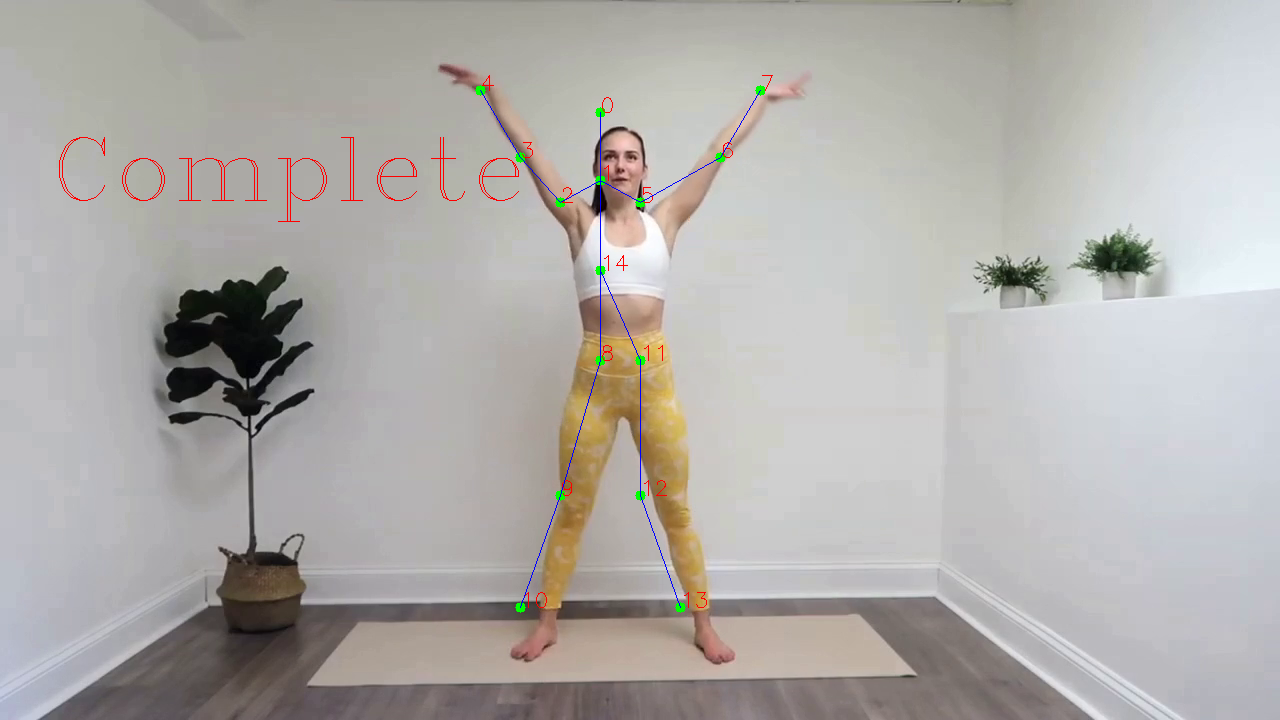

In [177]:

threshold = 0.3
while cv2.waitKey(1) < 0:
  connected, frame = capture.read()

  if not connected:
    break

  image_blob = cv2.dnn.blobFromImage(image = frame, scalefactor = 1.0 / 255, size = (256, 256))
  network.setInput(image_blob)
  output = network.forward()
  position_height = output.shape[2]
  position_width = output.shape[3]

  num_points = 15
  points = []
  for i in range(num_points):
    confidence_map = output[0, i, :, :]
    _, confidence, _, point = cv2.minMaxLoc(confidence_map)
    x = int((frame.shape[1] * point[0]) / position_width)
    y = int((frame.shape[0] * point[1]) / position_height)
    if confidence > threshold:
      cv2.circle(frame, (x, y), 5, (0,255,0), thickness = -1)
      cv2.putText(frame, "{}".format(i), (x, y), cv2.FONT_HERSHEY_SIMPLEX, .7, (0, 0, 255))
      points.append((x, y))
    else:
      points.append(None)

  for connection in point_connections:
    partA = connection[0]
    partB = connection[1]
    if points[partA] and points[partB]:
      cv2.line(frame, points[partA], points[partB], (255,0,0))
  if None not in points:
    if verify_arms_up(points) == 'Arms are above the head':
      cv2.putText(frame, 'Complete', (50,200), cv2.FONT_HERSHEY_COMPLEX, 3, (0,0,255))
      cv2_imshow(frame)
    save_video.write(frame)


save_video.release()